In [1]:
import scipy.fftpack
import numpy as np
import os
from mvalab_v2 import visusar, visusarspectre
from PIL import Image

In [2]:
def store_data_and_plot(im, threshold, filename):
    """
    Saves an image after thresholding and scaling.

    Parameters:
    - im (np.array): SAR image (real-valued).
    - threshold (float): Maximum intensity for normalization.
    - filename (str): File path to save.
    """
    im = np.abs(im)  # Convert complex to magnitude
    im = np.clip(im, 0, threshold)  # Apply threshold
    im = (im / threshold * 255).astype(np.uint8)  # Normalize to [0,255]

    # Ensure filename ends with .png
    filename = filename if filename.endswith('.png') else filename + '.png'

    Image.fromarray(im).convert('L').save(filename)

def save_sar_images(denoised, noisy, imagename, save_dir):
    """
    Saves the denoised SAR image and ensures correct file naming.

    Parameters:
    - denoised (np.array): Processed SAR image.
    - noisy (np.array): Original SAR image.
    - imagename (str): Name of the image.
    - save_dir (str): Directory to save images.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create directory if it doesn't exist

    threshold = np.mean(np.abs(noisy)) + 3 * np.std(np.abs(noisy))  # Compute threshold from noisy image

    denoisedfilename = os.path.join(save_dir, imagename + ".npy")
    np.save(denoisedfilename, denoised)

    store_data_and_plot(denoised, threshold, denoisedfilename.replace('.npy', ''))  # Save as .png

In [3]:
def create_2d_window(shape, window_type='hann'):
    """
    Creates a smooth 2D window (Hann or Hamming) for frequency domain smoothing.
    """
    if window_type == 'hann':
        win_row = np.hanning(shape[0])
        win_col = np.hanning(shape[1])
    elif window_type == 'hamming':
        win_row = np.hamming(shape[0])
        win_col = np.hamming(shape[1])
    else:
        raise ValueError("Unsupported window type")

    return np.outer(win_row, win_col)


def find_best_subbands_around_peak(image, df_width_ratio=0.2, col_df_ratio=0.2,
                                   skip_bands_below=1, skip_bands_above=1):
    if not np.iscomplexobj(image):
        raise ValueError("Expected a complex SAR image.")

    image_fft = scipy.fftpack.fftshift(scipy.fftpack.fft2(image))
    magnitude_spectrum = np.abs(image_fft)

    energy = magnitude_spectrum ** 2
    total_energy = np.sum(energy, axis=1)

    peak_index = np.argmax(total_energy)
    nlig, ncol = image.shape
    df_width = int(df_width_ratio * nlig)

    f1_below = np.maximum(peak_index - df_width - skip_bands_below, 0)
    df_below = df_width

    f1_above = peak_index + skip_bands_above
    df_above = np.minimum(nlig - f1_above, df_width)

    col_df = int(col_df_ratio * ncol)
    col_subbands = [
        (0, col_df),
        (ncol - col_df, col_df)
    ]

    if df_above < 0:
        selected_subbands = [((f1_below, df_below), col) for col in col_subbands]
    else:
        selected_subbands = (
            [((f1_below, df_below), col) for col in col_subbands] +
            [((f1_above, df_above), col) for col in col_subbands]
        )

    print(f"Selected Subbands: {selected_subbands}")
    return selected_subbands


def extract_specific_subbands(image, subband_ranges, window_type='hann', display=False):
    if not np.iscomplexobj(image):
        raise ValueError("Expected a complex SAR image.")

    image_fft = scipy.fftpack.fftshift(scipy.fftpack.fft2(image))
    nlig, ncol = image.shape
    filtered_images = {}

    for ((f1, df), (col_f1, col_df)) in subband_ranges:
        if f1 < 0 or f1 + df > nlig or col_f1 < 0 or col_f1 + col_df > ncol:
            print(f"Skipping out-of-bounds subband: Row={f1}-{f1+df}, Col={col_f1}-{col_f1+col_df}")
            continue

        print(f"Extracting: Row={f1}-{f1+df}, Col={col_f1}-{col_f1+col_df}")

        filtered_fft = np.zeros((nlig, ncol), dtype=complex)
        window = create_2d_window((df, col_df), window_type=window_type)

        filtered_fft[f1:f1 + df, col_f1:col_f1 + col_df] = (
            image_fft[f1:f1 + df, col_f1:col_f1 + col_df] * window
        )

        filtered_image = scipy.fftpack.ifft2(scipy.fftpack.fftshift(filtered_fft))
        filtered_images[((f1, df), (col_f1, col_df))] = filtered_image

        if display:
            visusarspectre(filtered_image, f"Subband {(f1, df)} x {(col_f1, col_df)}")

    return filtered_images


def combine_subbands(subband_images, method="min_energy"):
    if len(subband_images) < 2:
        raise ValueError("This function requires at least two subband images!")

    abs_images = np.stack([np.abs(img) for img in subband_images])

    if method == "min_energy":
        combined_image = np.minimum.reduce(abs_images)

    elif method == "median":
        combined_image = np.median(abs_images, axis=0)

    elif method == "weighted":
        weights = 1.0 / (abs_images + 1e-6)
        weights_sum = np.sum(weights, axis=0)
        combined_image = np.sum(abs_images * weights, axis=0) / weights_sum
        
    elif method == "and":
        threshold = 0.5 * np.mean([np.abs(img) for img in subband_images])
        feature_masks = np.array([np.abs(img) > threshold for img in subband_images])

        # Compute final AND mask (only features present in all subbands)
        final_mask = np.all(feature_masks, axis=0)

        combined_image = np.sum(subband_images, axis=0) * final_mask

        # normalization_factor = np.maximum(1, np.sum(final_mask))
        # combined_image /= normalization_factor

    else:
        raise ValueError("Invalid method. Choose 'min_energy', 'weighted', or 'median'.")

    return combined_image
    

Selected Subbands: [((0, 2250), (0, 600)), ((0, 2250), (2400, 600)), ((2718, 1782), (0, 600)), ((2718, 1782), (2400, 600))]
Extracting: Row=0-2250, Col=0-600
Extracting: Row=0-2250, Col=2400-3000
Extracting: Row=2718-4500, Col=0-600
Extracting: Row=2718-4500, Col=2400-3000


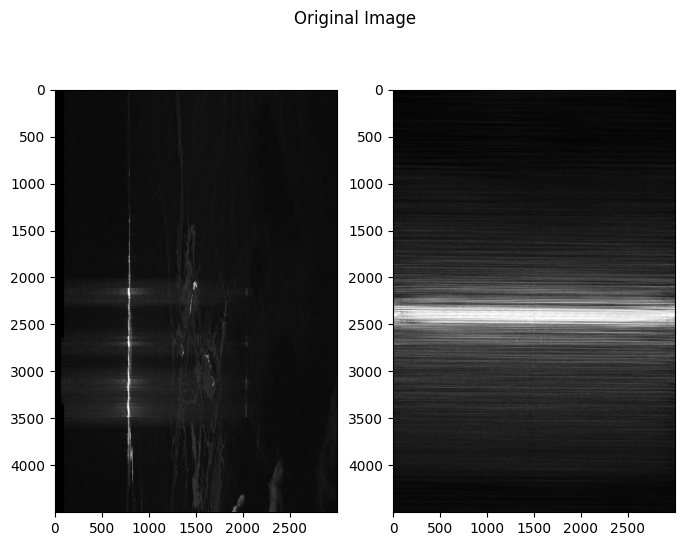

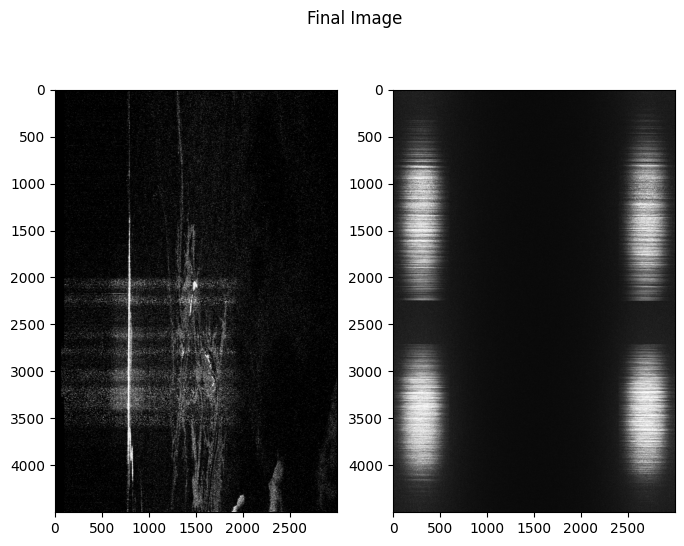

Affichage d'une image reelle


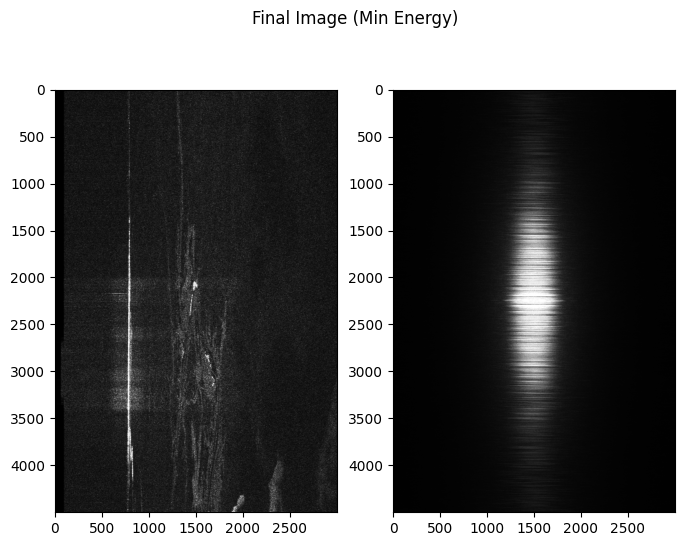

Affichage d'une image reelle


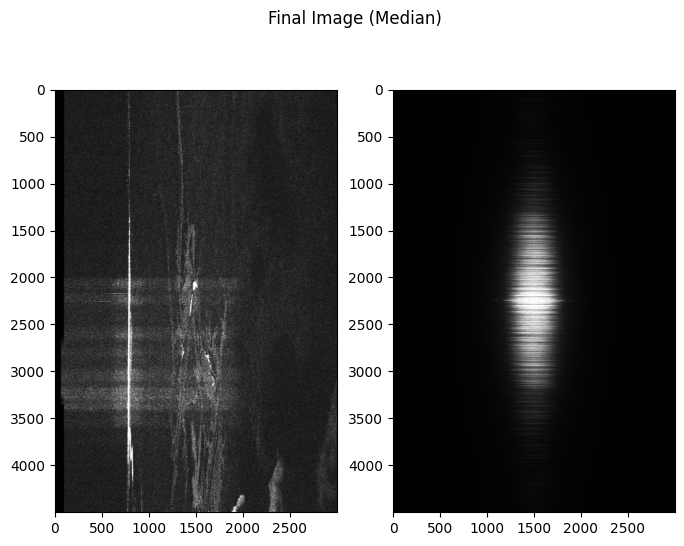

In [11]:
# Example usage:
if __name__ == "__main__":
    sar_image = np.load("./dataset/test/SLC_015_117_151R_minus_y_pola_H.npy")
    sar_image = sar_image[:, :, 0] + sar_image[:, :, 1] * 1j

    nlig, ncol = sar_image.shape
    best_subbands = find_best_subbands_around_peak(
        sar_image, df_width_ratio=0.5, col_df_ratio=0.2,
        skip_bands_below=int(nlig*0.07), skip_bands_above=int(nlig*0.07)
    )

    extracted = extract_specific_subbands(sar_image, best_subbands, window_type='hamming', display=False)
    subband_images = list(extracted.values())
    final = combine_subbands(subband_images, method="and")    
    
    visusarspectre(sar_image, "Original Image")
    visusarspectre(final, "Final Image")


In [ ]:
def process_sar_images(input_folder, hr_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    sar_files = [f for f in os.listdir(input_folder) if f.endswith(".npy")]

    for file_name in sar_files:
        file_path = os.path.join(input_folder, file_name)
        print(f"Processing: {file_name}")
        
        sar_image = np.load(file_path)
        sar_image = sar_image[:, :, 0] + sar_image[:, :, 1] * 1j
        
        nlig, _ = sar_image.shape
        best_subbands = find_best_subbands_around_peak(sar_image, df_width_ratio=0.5, col_df_ratio=0.2, 
                                                       skip_bands_below = int(nlig*0.07), skip_bands_above = int(nlig*0.07))
        extracted_subbands = extract_specific_subbands(sar_image, best_subbands, window_type='hann', display=False)
        subband_images = list(extracted_subbands.values())
        final_image = combine_subbands(np.abs(subband_images), method="and")

        # visusarspectre(final_image, "Final Image")
        
        # Save aligned image
        base_name = os.path.splitext(file_name)[0]  # Remove .npy extension
        save_sar_images(final_image, final_image, f"{base_name}", output_folder)

        print("Processing complete.")

# Example usage
input_folder = "./dataset/test"
output_folder = "./No_specular_ringing"
hr_folder = "../SAR-SuperResolution/data/HR"
process_sar_images(input_folder, hr_folder, output_folder)

# Check

In [6]:
def crop_image(image, f1, df, col_f1, col_df, display=True):
    """
    Crops a specific section of the image.

    Parameters:
    - image (np.array): Input image (can be real or complex).
    - f1 (int): Starting row index.
    - df (int): Height of the cropped region.
    - col_f1 (int): Starting column index.
    - col_df (int): Width of the cropped region.
    - display (bool): If True, displays the cropped section.

    Returns:
    - np.array: Cropped image section.
    """
    # Ensure the cropping coordinates are within bounds
    nlig, ncol = image.shape
    f1_end = min(f1 + df, nlig)
    col_f1_end = min(col_f1 + col_df, ncol)

    cropped_section = image[f1:f1_end, col_f1:col_f1_end]

    if display:
        visusarspectre(cropped_section, f"Cropped Section (Row: {f1}-{f1_end}, Col: {col_f1}-{col_f1_end})")
        
    return cropped_section

In [7]:
sar_image = np.load("./dataset/test/SLC_024_430_045L_minus_y_pola_V.npy")
sar_image = sar_image[:, :, 0] + sar_image[:, :, 1] * 1j

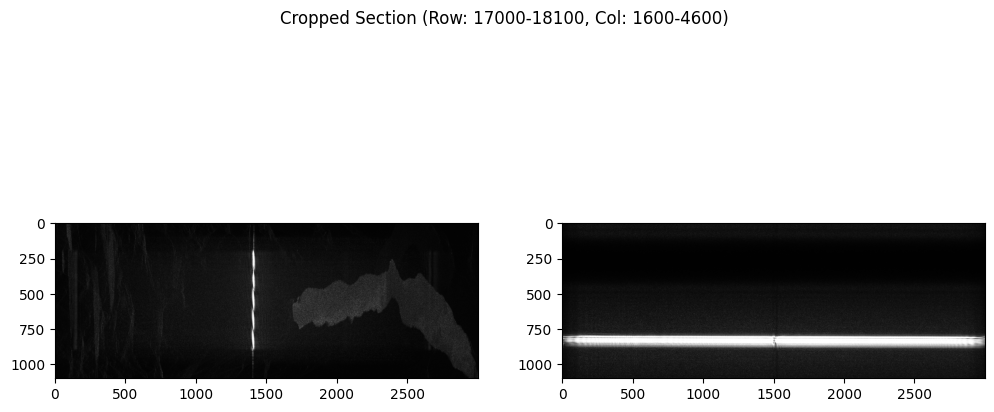

In [8]:
# Example usage:
f1, df = 17000, 1100  # Crop starting at row 500, with height 200
col_f1, col_df = 1600, 3000  # Crop starting at column 1000, with width 300

cropped_image = crop_image(sar_image, f1, df, col_f1, col_df)

Selected Subbands: [((0, 770), (0, 600)), ((0, 770), (2400, 600)), ((925, 175), (0, 600)), ((925, 175), (2400, 600))]
Extracting: Row=0-770, Col=0-600


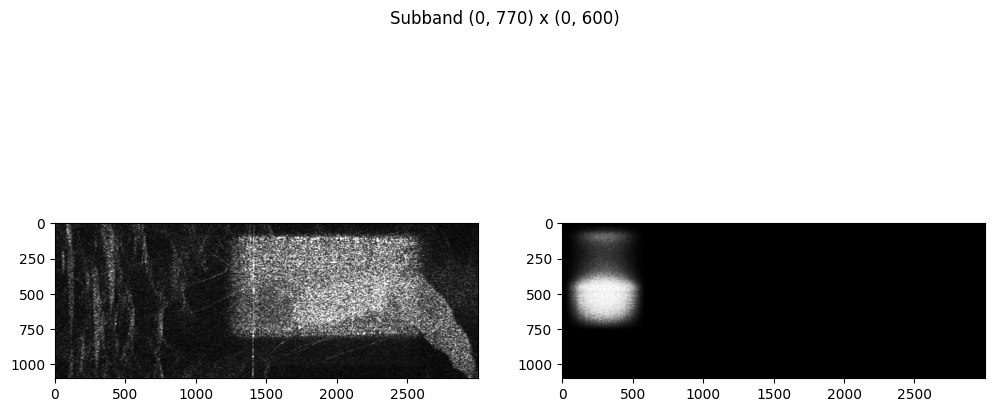

Extracting: Row=0-770, Col=2400-3000


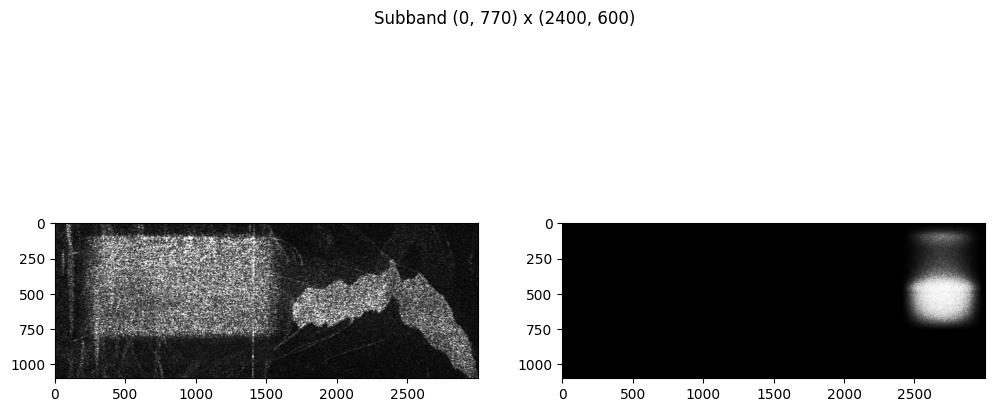

Extracting: Row=925-1100, Col=0-600


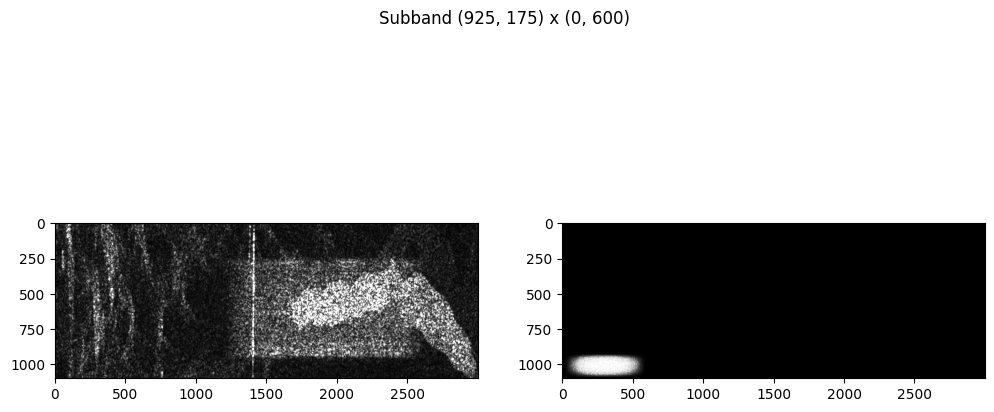

Extracting: Row=925-1100, Col=2400-3000


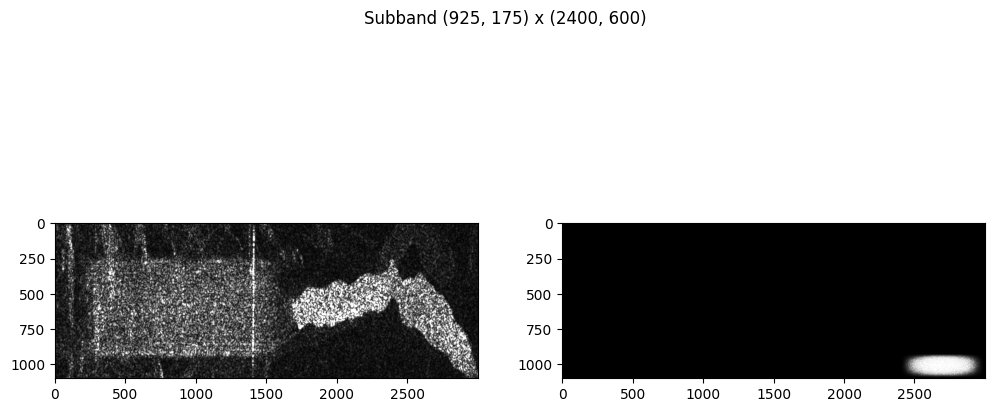

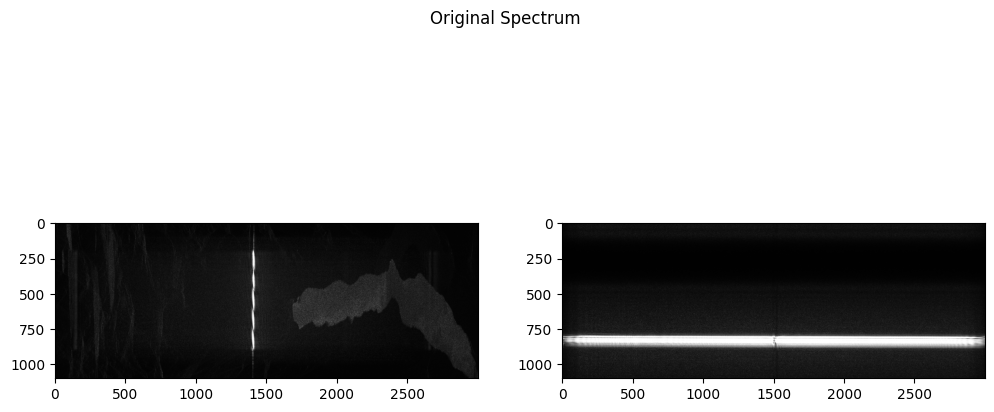

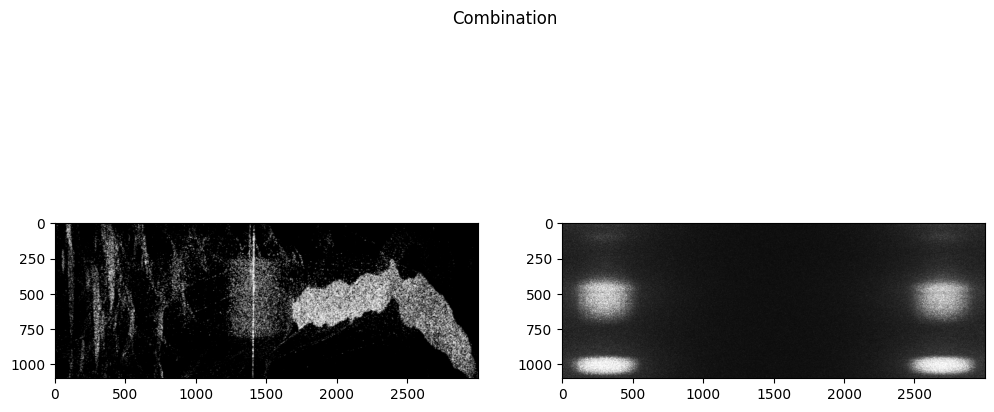

In [9]:
# Load the SAR image
nlig, ncol = cropped_image.shape

# Find the best subbands dynamically
best_subbands = find_best_subbands_around_peak(cropped_image, df_width_ratio=0.7, col_df_ratio=0.2, 
                                   skip_bands_below = int(nlig*0.09), skip_bands_above = int(nlig*0.09))

# Extract the best subbands
extracted_subbands = extract_specific_subbands(cropped_image, best_subbands, display=True)

# Convert dictionary to list of subband images
subband_images = list(extracted_subbands.values())

# Combine using different methods
final_image_and = combine_subbands(subband_images, method="and")

visusarspectre(cropped_image, "Original Spectrum")
visusarspectre(final_image_and, "Combination")